using pca and lda model
(9377, 31)


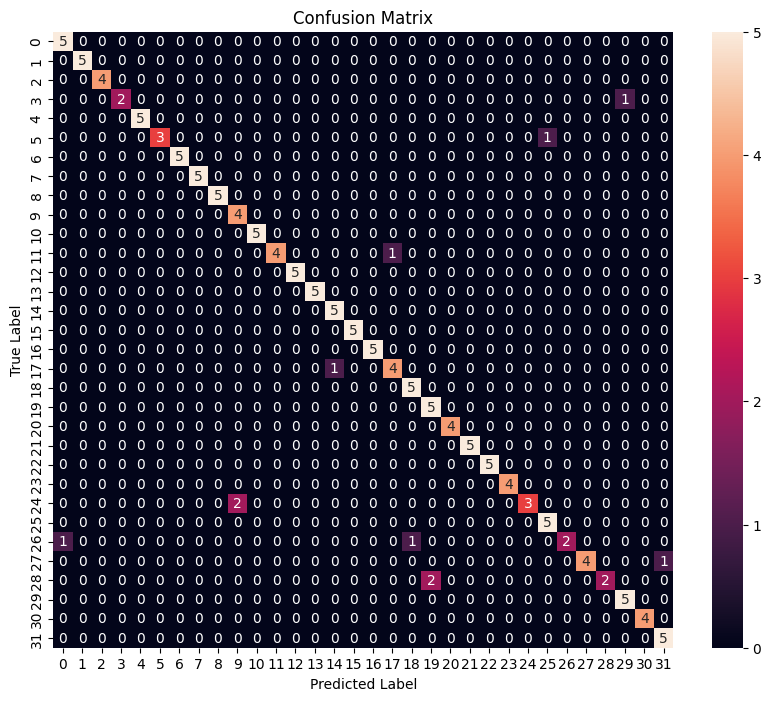

Accuracy: 0.9998933560840354 0.9266666666666666


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

data_dir = 'dimension_reduced_data'

use_pca = True
use_lda = True

if use_pca and not use_lda:
    print('using pca model')

    X_train = np.load('dimension_reduced_data/X_train_pca.npy')
    X_val = np.load('dimension_reduced_data/X_val_pca.npy')

if use_lda and not use_pca:
    print('using lda model')

    X_train = np.load('dimension_reduced_data/X_train_lda.npy')
    X_val = np.load('dimension_reduced_data/X_val_lda.npy')

if use_pca and use_lda:
    print('using pca and lda model')

    X_train = np.load('dimension_reduced_data/X_train_pca_lda.npy')
    X_val = np.load('dimension_reduced_data/X_val_pca_lda.npy')

y_train = np.load('dimension_reduced_data/y_train.npy')
y_val = np.load('dimension_reduced_data/y_val.npy')

print(X_train.shape)

# Define base learners with hyperparameter tuning
svm = SVC()
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(svm, svm_params, cv=3)
svm_grid.fit(X_train, y_train)

random_forest = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(random_forest, rf_params, cv=3)
rf_grid.fit(X_train, y_train)

knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7]}
knn_grid = GridSearchCV(knn, knn_params, cv=3)
knn_grid.fit(X_train, y_train)

# Train base learners with best parameters
svm_best = svm_grid.best_estimator_
random_forest_best = rf_grid.best_estimator_
knn_best = knn_grid.best_estimator_

# Make predictions
yp_train_svm = svm_best.predict(X_train)
yp_train_rf = random_forest_best.predict(X_train)
yp_train_knn = knn_best.predict(X_train)

# Ensemble predictions (majority voting)
yp_train_ensemble = np.array([np.argmax(np.bincount([yp_train_svm[i], yp_train_rf[i], yp_train_knn[i]])) for i in range(len(yp_train_svm))])

# Calculate training accuracy
training_accuracy = accuracy_score(y_train, yp_train_ensemble)

# Make predictions on validation data
yp_val_svm = svm_best.predict(X_val)
yp_val_rf = random_forest_best.predict(X_val)
yp_val_knn = knn_best.predict(X_val)

# Ensemble predictions for validation data
yp_val_ensemble = np.array([np.argmax(np.bincount([yp_val_svm[i], yp_val_rf[i], yp_val_knn[i]])) for i in range(len(yp_val_svm))])

# Calculate validation accuracy
validation_accuracy = accuracy_score(y_val, yp_val_ensemble)

# Calculate confusion matrix for validation data
cm = confusion_matrix(y_val, yp_val_ensemble)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("Accuracy:", training_accuracy, validation_accuracy)
